## Construct Predictive Model and Infer Response
Here we construct large bayes model to predict the associations between mutations and phenotype

In [1]:
import numpy 
import plotly as pl
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
import numpy as np
import random as random
np.random.seed(7678)
from sklearn.metrics import auc, roc_curve

import sys
sys.path.insert(0, '../MutCat/')
import ccal # Original repository is in https://github.com/UCSD-CCAL/ccal

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

pl.offline.init_notebook_mode(connected=True)

from ancillary_v1_0 import *

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

CCAL version 0.9.2 @ /home/ebc/variome/GIT/MutCat/MutCat/ccal/__init__.py


In [2]:
NRF2_RNA = pd.read_table('/home/ebc/variome/GIT/omphalos/analysis/NRF2_pathway/dataframes/step3/CCLE_NRF2_target.gct', header=None)
NRF2_RNA.rename(columns={0:'Tumor_Sample_Barcode',1:'RNA_signature'},inplace=True)
NRF2_RNA.set_index('Tumor_Sample_Barcode', inplace=True)

In [3]:
pathway = 'NRF2'
input_file_name = '/home/ebc/variome/GIT/omphalos/analysis/NRF2_pathway/dataframes/step3/mutations_NRF2v2_step3.csv' # clusters of mutations

path = '/home/ebc/variome/GIT/omphalos/analysis/NRF2_pathway/dataframes/step4/'

df = pd.read_csv(input_file_name,index_col=0)
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)

pathways_ds = pd.read_table('/home/ebc/variome/CT2/ccal_PT/Inference/data/CCLE_19Q3/CCLE_expression.PATHWAYS.c2_c5_h.gct',sep='\t', skiprows=2,index_col=0).drop('Description',1)

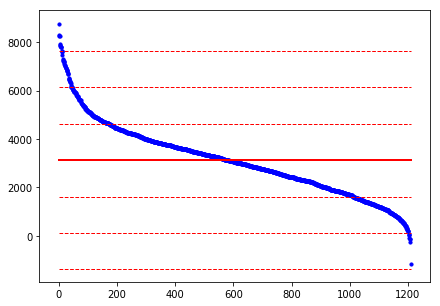

In [4]:
NRF2_sig = pathways_ds.loc['SINGH_NFE2L2_TARGETS',:].sort_values(ascending = False)
NRF2_sig_mean = NRF2_sig.mean()
NRF2_sig_std = NRF2_sig.std()

fig = plt.figure(figsize=(7, 5))
plt.plot([0, NRF2_sig.size], [NRF2_sig_mean, NRF2_sig_mean], color = 'red', lw=2, linestyle = 'solid')
for sigma in [range(-3, 3+1)]:
    plt.plot([0, NRF2_sig.size], [NRF2_sig_mean + sigma*NRF2_sig_std, NRF2_sig_mean + sigma*NRF2_sig_std], color = 'red', lw=1, linestyle = 'dashed')
plt.scatter(x = range(NRF2_sig.size), y = NRF2_sig, s = 10, c = 'blue', marker = 'o')


0    1036
1     174
Name: NRF2_Act, dtype: int64


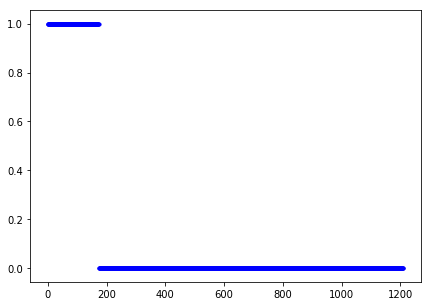

In [5]:
NRF2_Act = pd.Series(np.where(NRF2_sig >= NRF2_sig_mean + NRF2_sig_std, 1, 0), 
                     index = NRF2_sig.index, name='NRF2_Act')
print(NRF2_Act.value_counts())
fig = plt.figure(figsize=(7, 5))

plt.scatter(x = range(NRF2_Act.size), y = NRF2_Act, s = 10, c = 'blue', marker = 'o')


In [7]:
df['cluster_ID'] = [str(df.loc[i,'ID'])+'_'+str(df.loc[i,'cluster_grp']) for i in df.index]
df[['Tumor_Sample_Barcode','cluster_ID']].head(2)

,Tumor_Sample_Barcode,cluster_ID
0,OC316_OVARY,UCHL1_3KW5.A_a
1,OC314_OVARY,UCHL1_3KW5.A_a


In [14]:
cell_list = NRF2_Act.index.tolist()

cluster_components = pd.DataFrame(columns=cell_list)

df['cluster_ID'] = [str(df.loc[i,'ID'])+'_'+str(df.loc[i,'cluster_grp']) for i in df.index]

cluster_list = df.cluster_ID.unique().tolist()


for i in cluster_list:
    
    binary_list = []
    
    tmp = df[df.cluster_ID==i].Tumor_Sample_Barcode.unique().tolist()
    
    if len(tmp)>0:
    
        for j in cluster_components.columns:
            if j in tmp:
                binary_list.append(1)
            else:
                binary_list.append(0)

        cluster_components.at[i] = binary_list

#cluster_components = cluster_components.apply(pd.to_numeric)
cluster_components.head(2)    

,LC1F_LUNG,RERFLCMS_LUNG,HUH1_LIVER,SNU878_LIVER,NCIH2122_LUNG,NCIH1793_LUNG,LUDLU1_LUNG,NCIH460_LUNG,NCIH1792_LUNG,A498_KIDNEY,SNU475_LIVER,NCIH2023_LUNG,VMRCRCZ_KIDNEY,NCIH1437_LUNG,CAKI2_KIDNEY,NCIH1944_LUNG,JHOM1_OVARY,NCIH1651_LUNG,HCC2814_LUNG,KMRC20_KIDNEY,PC14_LUNG,HCC15_LUNG,LI7_LIVER,NCIH647_LUNG,NCIH2172_LUNG,RMUGS_OVARY,PC9_LUNG,TUHR10TKB_KIDNEY,NCIH2228_LUNG,PLCPRF5_LIVER,A549_LUNG,NCIH28_PLEURA,NCIH2030_LUNG,TFK1_BILIARY_TRACT,LXF289_LUNG,SLR23_KIDNEY,SKRC20_KIDNEY,H4_CENTRAL_NERVOUS_SYSTEM,AU565_BREAST,SNU387_LIVER,SNU16_STOMACH,SKLU1_LUNG,X769P_KIDNEY,VMRCRCW_KIDNEY,BT20_BREAST,SW1463_LARGE_INTESTINE,NCIH1648_LUNG,RERFLCSQ1_LUNG,TE14_OESOPHAGUS,HCT116_LARGE_INTESTINE,TT_OESOPHAGUS,SW1088_CENTRAL_NERVOUS_SYSTEM,MDAMB436_BREAST,NCIH1355_LUNG,DU145_PROSTATE,HUH6_LIVER,NCIH1623_LUNG,BC3C_URINARY_TRACT,ESO51_OESOPHAGUS,PACADD137_PANCREAS,IGR37_SKIN,NCIH838_LUNG,SUM159PT_BREAST,X59M_OVARY,K029AX_SKIN,MEL202_UVEA,KYSE180_OESOPHAGUS,KATOIII_STOMACH,TE11_OESOPHAGUS,OE21_OESOPHAGUS,MELHO_SKIN,BEN_LUNG,GSU_STOMACH,JHH7_LIVER,UMUC4_URINARY_TRACT,NCIH1435_LUNG,MERO41_PLEURA,SNU245_BILIARY_TRACT,OCUM1_STOMACH,T84_LARGE_INTESTINE,OUMS23_LARGE_INTESTINE,SNU638_STOMACH,NCIH2110_LUNG,SLR24_KIDNEY,MM370_SKIN,KMLS1_SOFT_TISSUE,SF172_CENTRAL_NERVOUS_SYSTEM,MIAPACA2_PANCREAS,OV90_OVARY,HLF_LIVER,C2BBE1_LARGE_INTESTINE,NCIH1563_LUNG,HLFA_FIBROBLAST,EFM192A_BREAST,A204_SOFT_TISSUE,HCC1438_LUNG,LN464_CENTRAL_NERVOUS_SYSTEM,HUH7_LIVER,NCIH1395_LUNG,NCIH1755_LUNG,CAKI1_KIDNEY,MDAMB415_BREAST,GP2D_LARGE_INTESTINE,BHT101_THYROID,BICR18_UPPER_AERODIGESTIVE_TRACT,MDAMB361_BREAST,SW1116_LARGE_INTESTINE,ESO26_OESOPHAGUS,T98G_CENTRAL_NERVOUS_SYSTEM,SUIT2_PANCREAS,HMY1_SKIN,MPP89_PLEURA,CCFSTTG1_CENTRAL_NERVOUS_SYSTEM,NCIH684_LARGE_INTESTINE,HEP3B217_LIVER,LN382_CENTRAL_NERVOUS_SYSTEM,SNU1272_KIDNEY,SKMEL5_SKIN,C84_LARGE_INTESTINE,MP46_UVEA,G361_SKIN,WM793_SKIN,CAL12T_LUNG,C396_BONE,BFTC909_KIDNEY,SNU1105_CENTRAL_NERVOUS_SYSTEM,A704_KIDNEY,FADU_UPPER_AERODIGESTIVE_TRACT,CAL72_BONE,X786O_KIDNEY,J82_URINARY_TRACT,KYSE520_OESOPHAGUS,IGR39_SKIN,SNU886_LIVER,NCIH322_LUNG,KMRC2_KIDNEY,KYSE70_OESOPHAGUS,HCC44_LUNG,CACO2_LARGE_INTESTINE,HS675T_FIBROBLAST,OSRC2_KIDNEY,SNU61_LARGE_INTESTINE,NCIH2073_LUNG,HT55_LARGE_INTESTINE,OVTOKO_OVARY,JHH5_LIVER,HCC1954_BREAST,EKVX_LUNG,SLR26_KIDNEY,IGR1_SKIN,RBE_BILIARY_TRACT,GCT_SOFT_TISSUE,NCIH2087_LUNG,NCIH1915_LUNG,SKMEL28_SKIN,OE19_OESOPHAGUS,NCIH2342_LUNG,DLD1_LARGE_INTESTINE,CL40_LARGE_INTESTINE,UACC893_BREAST,UACC257_SKIN,DMS454_LUNG,PACADD165_PANCREAS,F5_CENTRAL_NERVOUS_SYSTEM,NCIH2066_LUNG,SW579_THYROID,FU97_STOMACH,SKMEL31_SKIN,HCT15_LARGE_INTESTINE,TE6_OESOPHAGUS,A101D_SKIN,SLR21_KIDNEY,PACADD188_PANCREAS,SNU449_LIVER,COLO792_SKIN,TUHR4TKB_KIDNEY,SNU478_BILIARY_TRACT,HELA_CERVIX,MS751_CERVIX,HCC2157_BREAST,HS936T_SKIN,TE4_OESOPHAGUS,HCC827_LUNG,SNU308_BILIARY_TRACT,LN428_CENTRAL_NERVOUS_SYSTEM,JMURTK2_SOFT_TISSUE,HS578T_BREAST,PANC1_PANCREAS,RERFLCKJ_LUNG,RVH421_SKIN,MG63_BONE,HCC1428_BREAST,UOK101_KIDNEY,BT12_SOFT_TISSUE,OACM51_OESOPHAGUS,PACADD119_PANCREAS,SNU503_LARGE_INTESTINE,HEC50B_ENDOMETRIUM,NCIH520_LUNG,HCC2279_LUNG,TIG3TD_FIBROBLAST,BICR16_UPPER_AERODIGESTIVE_TRACT,IPC298_SKIN,HCC515_LUNG,HUG1N_STOMACH,SKBR3_BREAST,PANC0403_PANCREAS,NUGC4_STOMACH,SNUC4_LARGE_INTESTINE,ZR7530_BREAST,HEC1A_ENDOMETRIUM,HOP62_LUNG,SKOV3_OVARY,HS255T_FIBROBLAST,GAMG_CENTRAL_NERVOUS_SYSTEM,TO175T_FIBROBLAST,NCIH1573_LUNG,NCIH2882_LUNG,HS819T_FIBROBLAST,NCIH196_LUNG,EGI1_BILIARY_TRACT,HS600T_FIBROBLAST,TUHR14TKB_KIDNEY,A375_SKIN,NCIH1339_LUNG,MORCPR_LUNG,DM3_FIBROBLAST,SNU5_STOMACH,RPMI7951_SKIN,SKMES1_LUNG,SKMEL2_SKIN,SISO_CERVIX,ACCMESO1_PLEURA,U343_CENTRAL_NERVOUS_SYSTEM,SF126_CENTRAL_NERVOUS_SYSTEM,PATU8988S_PANCREAS,X42MGBA_CENTRAL_NERVOUS_SYSTEM,HPAC_PANCREAS,HS618T_FIBROBLAST,HS606T_FIBROBLAST,TF1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH1838_LUNG,HCC95_LUNG,X93T449_SOFT_TISSUE,LU99_LUNG,SNU423_LIVER,SW780_URINARY_TRACT,ONDA9_CENTRAL_NERVOUS_SYSTEM,JHH6_LIVER,KMS11_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,CJM_SKIN,KA

# Feature Engineering

In [15]:
matching_scores = ccal.make_match_panel(
                            target = NRF2_Act,
                            target_ascending = False,
                            target_type = 'binary',
                            n_permutation = 100, 
                            n_extreme = 10, 
                            score_ascending =  False,           
                            data_type = 'binary',
                            title= 'NRF2 Binary Activation vs 3D mutation clusters',
                            data = cluster_components,
                            file_path_prefix = '/home/ebc/variome/CT2/ONCO-GPS_FVRs/NRF2_pathway/analysis/match_NRF2')

target.index (1210) & data.columns (1210) have 1210 in common.
Computing score using compute_information_coefficient with 1 process ...
Computing MoE with 0 sampling ...
Computing p-value and FDR with 100 permutation ...
Clustering heat map within category ...


In [23]:
matching_scores.to_csv('/home/ebc/variome/GIT/MutCat/analysis/NRF2/dataframes/step4/match_NRF2.tsv')

match_panel_results = pd.read_table('/home/ebc/variome/GIT/MutCat/analysis/NRF2/dataframes/step4/match_NRF2.tsv', index_col=0,sep=',')

match_panel_results['FDR'] = match_panel_results['FDR'].astype(float)
match_panel_results['Score'] = match_panel_results['Score'].astype(float)
match_panel_results['0.95 MoE'] = match_panel_results['0.95 MoE'].astype(float)
match_panel_results['P-Value'] = match_panel_results['P-Value'].astype(float)

list_clusters = match_panel_results.index

match_panel_results.head(10)

,Score,0.95 MoE,P-Value,FDR
AKR1C4_2FVL.C_o_q_nn,0.172854,NaN,0.000018,0.000417
AKR1C4_2FVL.C_q,0.172077,NaN,0.000018,0.000417
KEAP1_4L7B.B_a_b_c_d_e_f_g_h_i_j_k_l_m_n_o_p_q_r_s_t_u_v_w_x_y_z_aa_bb_cc_dd_ee_ff_gg_hh_ii_jj_kk_ll_mm_nn_oo_pp_qq_rr_ss_tt_uu_vv_ww_xx_yy_zz_aaa_bbb_ccc_ddd_eee_fff,0.169402,NaN,0.000018,0.000417
AKR1C4_2FVL.C_a_o_q_v_nn_oo,0.166182,NaN,0.000018,0.000417
AKR1C4_2FVL.C_a_b_c_d_e_f_g_h_i_j_k_l_m_n_o_p_q_r_s_t_u_v_w_x_y_z_aa_bb_cc_dd_ee_ff_gg_hh_ii_jj_kk_ll_mm_nn_oo_pp_qq_rr_ss_tt_uu_vv_ww_xx,0.163833,NaN,0.000018,0.000417
AKR1C4_2FVL.C_n,0.163283,NaN,0.000018,0.000417
KEAP1_4L7B.B_a_b_d_e_f_g_h_i_j_k_l_m_n_o_p_q_r_s_t_u_v_w_x_y_z_aa_bb_cc_dd_ee_ff_gg_hh_ii_jj_kk_ll_mm_nn_oo_pp_qq_rr_ss_tt_uu_vv_ww_xx_yy_zz_aaa_bbb_ccc_ddd_eee,0.162731,NaN,0.000018,0.000417
AKR1C4_2FVL.C_a_c_d_e_g_h_i_k_l_m_n_o_p_q_r_s_t_u_v_w_x_z_bb_dd_ee_ff_gg_hh_jj_kk_ll_mm_nn_oo_pp_qq_rr_ss_tt_uu_vv_ww,0.155908,NaN,0.000018,0.000417
AKR1C4_2FVL.C_n_kk,0.155467,NaN,0.000018,0.000417
AKR1C4_2FVL.C_a_n_o_q_v_kk_ll_nn_oo_rr,0.154720,NaN,0.000018,0.000417


In [26]:
binary_RNA = pd.DataFrame(columns=['NRF2'])

threshold = np.percentile(NRF2_RNA.values,80)

for i in NRF2_RNA.index:
    if NRF2_RNA[i]>threshold:
        binary_RNA.at[i,'NRF2'] = 1
    else:
        binary_RNA.at[i,'NRF2'] = 0
        
binary_RNA = binary_RNA.loc[:, 'NRF2']

#### Reformulate data

In [37]:
overlap = set(NRF2_Act.index).intersection(set(cluster_components.columns))
overlap = np.sort(list(overlap))
cluster_components = cluster_components.loc[:, overlap]


NRF2_Act = NRF2_Act.loc[overlap]
print(cluster_components.shape)
print(NRF2_Act.size)

(563, 1210)
1210


In [27]:
cluster_dict = {}
for i in df.Hugo_Symbol.unique():
    cluster_dict[i] = {}
    count = 0
    for j in df[df.Hugo_Symbol==i].structureChainId.unique():
        count = 0
        for k in df[(df.Hugo_Symbol==i)&(df.structureChainId==j)].cluster_grp.unique():
            count +=1
            
        cluster_dict[i][j] = count
cluster_dict

{'UCHL1': {'3KW5.A': 10},
 'KEAP1': {'4L7B.B': 58, '4CXT.A': 18},
 'TXNRD1': {'3QFB.A': 43},
 'RAB6B': {'2FFQ.A': 30},
 'GSTM3': {'3GTU.D': 23},
 'G6PD': {'1QKI.F': 40},
 'CUL3': {'4APF.B': 45, '4EOZ.B': 53},
 'AKR1B10': {'1ZUA.X': 34},
 'AKR1C4': {'2FVL.C': 50},
 'SIRT1': {'5BTR.A': 29},
 'NTRK2': {'4AT5.A': 36, '1WWB.X': 8},
 'NFE2L2': {'4IFL.P': 10, '2FLU.P': 10},
 'AKR1C3': {'4ZFC.B': 27},
 'AKR1C2': {'4XO6.B': 23},
 'SRXN1': {'2RII.X': 7},
 'NQO1': {'5EA2.A': 9}}

In [33]:
gene_features = [i for i in cluster_dict.keys()]

cluster_features = match_panel_results.index[0:3].tolist()
sel_muts = cluster_components.loc[cluster_features,:]
sel_muts.sum(axis=1)

AKR1C4_2FVL.C_o_q_nn                                                                                                                                                      16.0
AKR1C4_2FVL.C_q                                                                                                                                                           14.0
KEAP1_4L7B.B_a_b_c_d_e_f_g_h_i_j_k_l_m_n_o_p_q_r_s_t_u_v_w_x_y_z_aa_bb_cc_dd_ee_ff_gg_hh_ii_jj_kk_ll_mm_nn_oo_pp_qq_rr_ss_tt_uu_vv_ww_xx_yy_zz_aaa_bbb_ccc_ddd_eee_fff    42.0
dtype: float64

In [139]:
cl1 = cluster_components.loc['AKR1C4_2FVL.C_o_q_nn',:]
cl2 = cluster_components.loc['AKR1C4_2FVL.C_q',:]
cl3 = cluster_components.loc['KEAP1_4L7B.B_r',:]
N = len(overlap)

print(len(cl1),N)

1210 1210


In [140]:
prob_cl1 = pd.Series(cl1.value_counts()/N, name = 'prob_cl1')
print(prob_cl1.sum())
print(prob_cl1)

prob_cl2 = pd.Series(cl2.value_counts()/N, name = 'prob_cl2')
print(prob_cl2.sum())
print(prob_cl2)

prob_cl3 = pd.Series(cl3.value_counts()/N, name = 'prob_cl3')
print(prob_cl3.sum())
print(prob_cl3) 

1.0
0.0    0.986777
1.0    0.013223
Name: prob_cl1, dtype: float64
1.0
0.0    0.98843
1.0    0.01157
Name: prob_cl2, dtype: float64
1.0
0.0    1.0
Name: prob_cl3, dtype: float64


In [188]:
len(cl1[cl1>0])

16

In [141]:
prob_Act = pd.Series(NRF2_Act.value_counts()/N, name = 'prob_Act')
print(prob_Act.sum())
print(prob_Act)

1.0
0    0.856198
1    0.143802
Name: prob_Act, dtype: float64


## Compute joint and conditional probablities

In [142]:
joint_counts_Act_vs_cl1 = pd.crosstab(NRF2_Act, cl1)
joint_counts_Act_vs_cl1

AKR1C4_2FVL.C_o_q_nn,0.0,1.0
NRF2_Act,,
0,1033,3
1,161,13


In [143]:
joint_counts_Act_vs_cl2 = pd.crosstab(NRF2_Act, cl2)
joint_counts_Act_vs_cl2

AKR1C4_2FVL.C_q,0.0,1.0
NRF2_Act,,
0,1034,2
1,162,12


In [144]:
joint_counts_Act_vs_cl3 = pd.crosstab(NRF2_Act, cl3)
joint_counts_Act_vs_cl3

KEAP1_4L7B.B_r,0.0
NRF2_Act,
0,1036
1,174


In [145]:
joint_prob_Act_vs_cl1 = joint_counts_Act_vs_cl1/N
print(joint_prob_Act_vs_cl1.sum().sum())
joint_prob_Act_vs_cl1

1.0


AKR1C4_2FVL.C_o_q_nn,0.0,1.0
NRF2_Act,,
0,0.853719,0.002479
1,0.133058,0.010744


In [146]:
joint_prob_Act_vs_cl2 = joint_counts_Act_vs_cl2/N
print(joint_prob_Act_vs_cl2.sum().sum())
joint_prob_Act_vs_cl2

0.9999999999999999


AKR1C4_2FVL.C_q,0.0,1.0
NRF2_Act,,
0,0.854545,0.001653
1,0.133884,0.009917


In [147]:
joint_prob_Act_vs_cl3 = joint_counts_Act_vs_cl3/N
print(joint_prob_Act_vs_cl3.sum().sum())
joint_prob_Act_vs_cl3

1.0


KEAP1_4L7B.B_r,0.0
NRF2_Act,
0,0.856198
1,0.143802


### P(x | y) = P(x, y) / P(y)    Adding the rows in each column of P(x | y) should produce 1 (normalization)

In [49]:
cond_prob_Act_given_cl1 = joint_prob_Act_vs_cl1.div(prob_cl1, axis='columns')
print(cond_prob_Act_given_cl1.sum(axis=0))
cond_prob_Act_given_cl1

AKR1C4_2FVL.C_o_q_nn
0.0    1.0
1.0    1.0
dtype: float64


AKR1C4_2FVL.C_o_q_nn,0.0,1.0
NRF2_Act,,
0,0.865159,0.1875
1,0.134841,0.8125


In [50]:
cond_prob_Act_given_cl2 = joint_prob_Act_vs_cl2.div(prob_cl2, axis='columns')
print(cond_prob_Act_given_cl2.sum(axis=0))
cond_prob_Act_given_cl2

AKR1C4_2FVL.C_q
0.0    1.0
1.0    1.0
dtype: float64


AKR1C4_2FVL.C_q,0.0,1.0
NRF2_Act,,
0,0.864548,0.142857
1,0.135452,0.857143


In [51]:
cond_prob_Act_given_cl3 = joint_prob_Act_vs_cl3.div(prob_cl3, axis='columns')
print(cond_prob_Act_given_cl3.sum(axis=0))
cond_prob_Act_given_cl3

KEAP1_4L7B.B_a_b_c_d_e_f_g_h_i_j_k_l_m_n_o_p_q_r_s_t_u_v_w_x_y_z_aa_bb_cc_dd_ee_ff_gg_hh_ii_jj_kk_ll_mm_nn_oo_pp_qq_rr_ss_tt_uu_vv_ww_xx_yy_zz_aaa_bbb_ccc_ddd_eee_fff
0.0    1.0
1.0    1.0
dtype: float64


KEAP1_4L7B.B_a_b_c_d_e_f_g_h_i_j_k_l_m_n_o_p_q_r_s_t_u_v_w_x_y_z_aa_bb_cc_dd_ee_ff_gg_hh_ii_jj_kk_ll_mm_nn_oo_pp_qq_rr_ss_tt_uu_vv_ww_xx_yy_zz_aaa_bbb_ccc_ddd_eee_fff,0.0,1.0
NRF2_Act,,
0,0.869863,0.47619
1,0.130137,0.52381


## Construct Table of Probabilities

In [201]:
def get_probabilities(NRF2_Act, cluster_components, cluster):
    
    overlap = set(NRF2_Act.index).intersection(set(cluster_components.columns))
    overlap = np.sort(list(overlap))
    df = cluster_components.loc[:, overlap]
    NRF2_Act = NRF2_Act.loc[overlap]
    
    N = len(overlap)

    c = df.loc[cluster,:]
    
    if len(c[c>0])>1:
    
        #Marginal Probabilities

        prob_c = pd.Series(c.value_counts()/N, name = 'prob_c')
        sum_prob_c = prob_c.sum()

        prob_Act = pd.Series(NRF2_Act.value_counts()/N, name = 'prob_Act')
        sum_prob_Act = prob_Act.sum()

        # Joint Probabilities

        joint_counts_Act_vs_c = pd.crosstab(NRF2_Act, c)
        joint_prob_Act_vs_c = joint_counts_Act_vs_c/N
        joint_prob_sum = joint_prob_Act_vs_c.sum().sum()
        
        Num_act_in_sample_set = joint_counts_Act_vs_c.values[1][1]
        Num_unact_in_sample_set = joint_counts_Act_vs_c.values[0][1]


        # Conditional Probability

        cond_prob_Act_given_c = joint_prob_Act_vs_c.div(prob_c, axis='columns')
        cond_prob_sum = np.mean(cond_prob_Act_given_cl1.sum(axis=0).values)

        try:
            cond_prob_1_1 = np.round(cond_prob_Act_given_c, decimals=3).values[1][1]
            cond_prob_1_0 = np.round(cond_prob_Act_given_c, decimals=3).values[1][0]
            cond_prob_0_0 = np.round(cond_prob_Act_given_c, decimals=3).values[0][0]
            cond_prob_0_1 = np.round(cond_prob_Act_given_c, decimals=3).values[0][1]


        except IndexError:
            print(cluster,len(c[c>0]))

    

        P = pd.DataFrame([{'feature':cluster,'Num_act_in_sample_set':Num_act_in_sample_set,'Num_unact_in_sample_set':Num_unact_in_sample_set,'P(Act=1|c=1)':cond_prob_1_1,'P(Act=1|c=0)':cond_prob_1_0,'P(Act=0|c=1)':cond_prob_0_1,'P(Act=0|c=0)':cond_prob_0_0,'N':N,'prob_c':np.round(prob_c,decimals=3).values,'sum_prob_c':sum_prob_c,'prob_Act':np.round(prob_Act,decimals=3).values,'sum_prob_Act':sum_prob_Act,'joint_counts_Act_vs_c':np.round(joint_counts_Act_vs_c,decimals=3).values,'joint_prob_Act_vs_c':np.round(joint_prob_Act_vs_c,decimals=3).values,'sum_joint_prob':joint_prob_sum,'cond_prob_Act_given_c':np.round(cond_prob_Act_given_c, decimals=3).values,'sum_cond_prob':cond_prob_sum}])

        return P[['feature','N','Num_act_in_sample_set','Num_unact_in_sample_set','P(Act=1|c=1)','P(Act=1|c=0)','P(Act=0|c=1)','P(Act=0|c=0)','cond_prob_Act_given_c','joint_prob_Act_vs_c','joint_counts_Act_vs_c','prob_Act','prob_c','sum_cond_prob','sum_joint_prob','sum_prob_Act','sum_prob_c']]
    
    
    else:
        return pd.DataFrame()


In [202]:
cluster = 'AKR1C4_2FVL.C_o_q_nn'

tt = get_probabilities(NRF2_Act, cluster_components, cluster)
tt

,feature,N,Num_act_in_sample_set,Num_unact_in_sample_set,P(Act=1|c=1),P(Act=1|c=0),P(Act=0|c=1),P(Act=0|c=0),cond_prob_Act_given_c,joint_prob_Act_vs_c,joint_counts_Act_vs_c,prob_Act,prob_c,sum_cond_prob,sum_joint_prob,sum_prob_Act,sum_prob_c
0,AKR1C4_2FVL.C_o_q_nn,1210,13,3,0.812,0.135,0.188,0.865,"[[0.865, 0.188], [0.135, 0.812]]","[[0.854, 0.002], [0.133, 0.011]]","[[1033, 3], [161, 13]]","[0.856, 0.144]","[0.987, 0.013]",1.0,1.0,1.0,1.0


In [203]:
DF_prob = pd.DataFrame()

for cluster in match_panel_results.index:
    
    tt = get_probabilities(NRF2_Act, cluster_components, cluster)
        
    if len(tt)>0:
        DF_prob = pd.concat([DF_prob, tt])

DF_prob.sort_values('P(Act=1|c=1)',ascending=False)


,feature,N,Num_act_in_sample_set,Num_unact_in_sample_set,P(Act=1|c=1),P(Act=1|c=0),P(Act=0|c=1),P(Act=0|c=0),cond_prob_Act_given_c,joint_prob_Act_vs_c,joint_counts_Act_vs_c,prob_Act,prob_c,sum_cond_prob,sum_joint_prob,sum_prob_Act,sum_prob_c
0,KEAP1_4L7B.B_a_ee,1210,3,0,1.000,0.142,0.000,0.858,"[[0.858, 0.0], [0.142, 1.0]]","[[0.856, 0.0], [0.141, 0.002]]","[[1036, 0], [171, 3]]","[0.856, 0.144]","[0.998, 0.002]",1.0,1.0,1.0,1.0
0,AKR1C4_2FVL.C_p,1210,2,0,1.000,0.142,0.000,0.858,"[[0.858, 0.0], [0.142, 1.0]]","[[0.856, 0.0], [0.142, 0.002]]","[[1036, 0], [172, 2]]","[0.856, 0.144]","[0.998, 0.002]",1.0,1.0,1.0,1.0
0,KEAP1_4L7B.B_q_aa,1210,3,0,1.000,0.142,0.000,0.858,"[[0.858, 0.0], [0.142, 1.0]]","[[0.856, 0.0], [0.141, 0.002]]","[[1036, 0], [171, 3]]","[0.856, 0.144]","[0.998, 0.002]",1.0,1.0,1.0,1.0
0,AKR1C4_2FVL.C_j_aa_cc,1210,6,0,1.000,0.140,0.000,0.860,"[[0.86, 0.0], [0.14, 1.0]]","[[0.856, 0.0], [0.139, 0.005]]","[[1036, 0], [168, 6]]","[0.856, 0.144]","[0.995, 0.005]",1.0,1.0,1.0,1.0
0,KEAP1_4L7B.B_p_dd,1210,3,0,1.000,0.142,0.000,0.858,"[[0.858, 0.0], [0.142, 1.0]]","[[0.856, 0.0], [0.141, 0.002]]","[[1036, 0], [171, 3]]","[0.856, 0.144]","[0.998, 0.002]",1.0,1.0,1.0,1.0
0,AKR1C2_4XO6.B_d_m,1210,2,0,1.000,0.142,0.000,0.858,"[[0.858, 0.0], [0.142, 1.0]]","[[0.856, 0.0], [0.142, 0.002]]","[[1036, 0], [172, 2]]","[0.856, 0.144]","[0.998, 0.002]",1.0,1.0,1.0,1.0
0,RAB6B_2FFQ.A_a,1210,2,0,1.000,0.142,0.000,0.858,"[[0.858, 0.0], [0.142, 1.0]]","[[0.856, 0.0], [0.142, 0.002]]","[[1036, 0], [172, 2]]","[0.856, 0.144]","[0.998, 0.002]",1.0,1.0,1.0,1.0
0,KEAP1_4L7B.B_q,1210,2,0,1.000,0.142,0.000,0.858,"[[0.858, 0.0], [0.142, 1.0]]","[[0.856, 0.0], [0.142, 0.002]]","[[1036, 0], [172, 2]]","[0.856, 0.144]","[0.998, 0.002]",1.0,1.0,1.0,1.0
0,AKR1C4_2FVL.C_j,1210,4,0,1.000,0.141,0.000,0.859,"[[0.859, 0.0], [0.141, 1.0]]","[[0.856, 0.0], [0.14, 0.003]]","[[1036, 0], [170, 4]]","[0.856, 0.144]","[0.997, 0.003]",1.0,1.0,1.0,1.0
0,KEAP1_4L7B.B_p,1210,2,0,1.000,0.142,0.000,0.858,"[[0.858, 0.0], [0.142, 1.0]]","[[0.856, 0.0], [0.142, 0.002]]","[[1036, 0], [172, 2]]","[0.856, 0.144]","[0.998, 0.002]",1.0,1.0,1.0,1.0


In [205]:
DF_prob[DF_prob.Num_act_in_sample_set>8].head(5)

,feature,N,Num_act_in_sample_set,Num_unact_in_sample_set,P(Act=1|c=1),P(Act=1|c=0),P(Act=0|c=1),P(Act=0|c=0),cond_prob_Act_given_c,joint_prob_Act_vs_c,joint_counts_Act_vs_c,prob_Act,prob_c,sum_cond_prob,sum_joint_prob,sum_prob_Act,sum_prob_c
0,AKR1C4_2FVL.C_o_q_nn,1210,13,3,0.812,0.135,0.188,0.865,"[[0.865, 0.188], [0.135, 0.812]]","[[0.854, 0.002], [0.133, 0.011]]","[[1033, 3], [161, 13]]","[0.856, 0.144]","[0.987, 0.013]",1.0,1.0,1.0,1.0
0,AKR1C4_2FVL.C_q,1210,12,2,0.857,0.135,0.143,0.865,"[[0.865, 0.143], [0.135, 0.857]]","[[0.855, 0.002], [0.134, 0.01]]","[[1034, 2], [162, 12]]","[0.856, 0.144]","[0.988, 0.012]",1.0,1.0,1.0,1.0
0,KEAP1_4L7B.B_a_b_c_d_e_f_g_h_i_j_k_l_m_n_o_p_q...,1210,22,20,0.524,0.130,0.476,0.870,"[[0.87, 0.476], [0.13, 0.524]]","[[0.84, 0.017], [0.126, 0.018]]","[[1016, 20], [152, 22]]","[0.856, 0.144]","[0.965, 0.035]",1.0,1.0,1.0,1.0
0,AKR1C4_2FVL.C_a_o_q_v_nn_oo,1210,13,4,0.765,0.135,0.235,0.865,"[[0.865, 0.235], [0.135, 0.765]]","[[0.853, 0.003], [0.133, 0.011]]","[[1032, 4], [161, 13]]","[0.856, 0.144]","[0.986, 0.014]",1.0,1.0,1.0,1.0
0,AKR1C4_2FVL.C_a_b_c_d_e_f_g_h_i_j_k_l_m_n_o_p_...,1210,22,22,0.500,0.130,0.500,0.870,"[[0.87, 0.5], [0.13, 0.5]]","[[0.838, 0.018], [0.126, 0.018]]","[[1014, 22], [152, 22]]","[0.856, 0.144]","[0.964, 0.036]",1.0,1.0,1.0,1.0


## Identify & Rank independent clusters

In [444]:
tmpdf=DF_prob[DF_prob.feature.str.startswith('KEAP1')]
tmpdf['total_mut']=np.add(tmpdf['Num_act_in_sample_set'],tmpdf['Num_unact_in_sample_set'])
tmpdf['ratio_act_un'] = np.true_divide(np.subtract(tmpdf['Num_act_in_sample_set'],tmpdf['Num_unact_in_sample_set']),tmpdf['total_mut'])


m = tmpdf[tmpdf['ratio_act_un'] != np.inf]['ratio_act_un'].min()
tmpdf['ratio_act_un'].replace(np.inf,m,inplace=True)
tmpdf[(tmpdf.ratio_act_un<.5)|(tmpdf.ratio_act_un>1.5)][['feature','Num_act_in_sample_set','Num_unact_in_sample_set','P(Act=1|c=1)','P(Act=0|c=1)','total_mut','ratio_act_un']].sort_values('ratio_act_un',ascending=True)

,feature,Num_act_in_sample_set,Num_unact_in_sample_set,P(Act=1|c=1),P(Act=0|c=1),total_mut,ratio_act_un
0,KEAP1_4L7B.B_j_r_s_y_bb_ff_oo_rr,0,6,0.000,1.000,6,-1.000000
0,KEAP1_4L7B.B_s_bb_ff,0,4,0.000,1.000,4,-1.000000
0,KEAP1_4CXT.A_a_c_i,0,4,0.000,1.000,4,-1.000000
0,KEAP1_4L7B.B_s_bb,0,3,0.000,1.000,3,-1.000000
0,KEAP1_4CXT.A_d_h,0,3,0.000,1.000,3,-1.000000
0,KEAP1_4CXT.A_d,0,2,0.000,1.000,2,-1.000000
0,KEAP1_4CXT.A_c,0,2,0.000,1.000,2,-1.000000
0,KEAP1_4CXT.A_a,0,2,0.000,1.000,2,-1.000000
0,KEAP1_4L7B.B_n,0,2,0.000,1.000,2,-1.000000
0,KEAP1_4L7B.B_r_s_y_bb_ff_oo,0,5,0.000,1.000,5,-1.000000


In [635]:
TopActClusters = {}
TopUnActClusters = {}

for i in cluster_dict.keys():
    
    TopActClusters[i]=[]
    TopUnActClusters[i]=[]
    
    for j in cluster_dict[i].keys():
        
        tmp = i+'_'+j
        
        tmpdf = DF_prob[DF_prob.feature.str.startswith(tmp)].reset_index()
        
        tmpdf['total_mut'] = np.add(tmpdf['Num_act_in_sample_set'],tmpdf['Num_unact_in_sample_set'])
        tmpdf['ratio_act_un'] = np.true_divide(np.subtract(tmpdf['Num_act_in_sample_set'],tmpdf['Num_unact_in_sample_set']),tmpdf['total_mut'])
        
        tmpdf = tmpdf.sort_values('total_mut',ascending=False)
        
        keep_Act = []
        keep_UnAct = []
        
        for k in tmpdf.index:
            
            if tmpdf.ix[k,'ratio_act_un'] <= -0.2:  # unactive case
                col = 'P(Act=0|c=1)'
            elif tmpdf.ix[k,'ratio_act_un'] >= 0.2:  # active case
                col = 'P(Act=1|c=1)'
            else:
                col = 'equally distributed'
                
            if col != 'equally distributed':
                
                tmp_prob = tmpdf.ix[k,col]
                tmp_feat = tmpdf.ix[k,'feature']
                tmp_clust_grp = tmpdf.ix[k,'feature'].split('_')[2:]
                tmp_total_mut = tmpdf.ix[k,'total_mut']
                tmp_ratio = tmpdf.ix[k,'ratio_act_un']

                if col == 'P(Act=0|c=1)':  # unactive case

                    if (len(keep_UnAct) > 0):
                        lst1=[]
                        for l in keep_UnAct:
                            if not lst1:
                                lst1 = l.split('_')[2:]
                            else:
                                lst1 = lst1 + l.split('_')[2:]
                                
                        if len(list(set(lst1) & set(tmp_clust_grp))) > 0:         # a nested cluster exists in keep
                                                                                 # find which specific cluster to replace, if needed
                            remove = []
                            for n in tmp_clust_grp:
                                remove = remove + [m for m, s in enumerate(keep_UnAct) if n in s]
                            
                            l = keep_UnAct[list(set(remove))[0]]     

                            try:
                                prior_prob = tmpdf[tmpdf.feature==l][col].values[0]
                                prior_total_mut = tmpdf[tmpdf.feature==l]['total_mut'].values[0]

                                per_change_total = np.true_divide(abs(prior_total_mut-tmp_total_mut),prior_total_mut)
                                per_change_prob = np.true_divide(abs(prior_prob-tmp_prob),prior_prob)

                                if (tmp_prob>prior_prob):#&(per_change_total<.7):
                                    keep_UnAct.remove(l)
                                    if tmp_feat not in keep_UnAct:
                                        keep_UnAct.append(tmp_feat)
                                    print(keep_UnAct)
                                    print("")
                            except IndexError:
                                pass
                        else:                                                     # otherwise, add it to keep
                            if tmp_feat not in keep_UnAct:
                                keep_UnAct.append(tmp_feat)
                                                                                
                        
                    else:
                        if tmp_feat not in keep_UnAct:
                            keep_UnAct.append(tmp_feat)
                        
                    

                else:  # active case

                    if (len(keep_Act) > 0):                                     # parse through all saved clusters to search substrings
                        lst1=[]
                        for l in keep_Act:
                            if not lst1:
                                lst1 = l.split('_')[2:]
                            else:
                                lst1 = lst1 + l.split('_')[2:]
                                
                        if len(list(set(lst1) & set(tmp_clust_grp))) > 0:         # a nested cluster exists in keep
                                                                                 # find which specific cluster to replace, if needed
                            remove = []                                         
                            for n in tmp_clust_grp:
                                remove = remove + [m for m, s in enumerate(keep_Act) if n in s]
                                
                            l = keep_Act[list(set(remove))[0]]     

                            try:
                                prior_prob = tmpdf[tmpdf.feature==l][col].values[0]
                                prior_prob = tmpdf[tmpdf.feature==l][col].values[0]
                                prior_total_mut = tmpdf[tmpdf.feature==l]['total_mut'].values[0]

                                per_change_total = np.true_divide(abs(prior_total_mut-tmp_total_mut),prior_total_mut)
                                per_change_prob = np.true_divide(abs(prior_prob-tmp_prob),prior_prob)

                                if (tmp_prob > prior_prob):# & (per_change_total<.7):  # using percent change to decide whether to replace it

                                #if tmp_prob > prior_prob:                   
                                    keep_Act.remove(l)
                                    print("I'm here")
                                    print(keep_Act)
                                    print(tmp_prob,">",prior_prob)
                                    print(tmp_feat,">",l)
                                    if tmp_feat not in keep_Act:
                                        keep_Act.append(tmp_feat)
                                    print(keep_Act)
                                    print("")
                            except IndexError:
                                pass
                        else:                                                     # otherwise, add it to keep
                            if tmp_feat not in keep_Act:
                                keep_Act.append(tmp_feat)
                                                                                
                        
                    else:
                        if tmp_feat not in keep_Act:
                            keep_Act.append(tmp_feat)
                            
        # 2nd pass to get other clusters based on probabilities
        
        tmpdf_down = tmpdf[tmpdf.ratio_act_un<=-0.2].sort_values('P(Act=0|c=1)',ascending=False)
        tmpdf_up = tmpdf[tmpdf.ratio_act_un>=0.2].sort_values('P(Act=1|c=1)',ascending=False)
        
            
        for k in tmpdf_down.index:
            
            col = 'P(Act=0|c=1)'
            tmp_prob = tmpdf.ix[k,col]
            tmp_feat = tmpdf.ix[k,'feature']
            tmp_clust_grp = tmpdf.ix[k,'feature'].split('_')[2:]
            
            if tmp_feat not in keep_UnAct:
                lst1=[]
                for l in keep_UnAct:
                    if not lst1:
                        lst1 = l.split('_')[2:]
                    else:
                        lst1 = lst1 + l.split('_')[2:]
                        
                if len(list(set(lst1) & set(tmp_clust_grp))) > 0:
                    pass
                else:
                    keep_UnAct.append(tmp_feat)
                    
        
        for k in tmpdf_up.index:
            
            col = 'P(Act=1|c=1)'
            tmp_prob = tmpdf.ix[k,col]
            tmp_feat = tmpdf.ix[k,'feature']
            tmp_clust_grp = tmpdf.ix[k,'feature'].split('_')[2:]
            
            if tmp_feat not in keep_Act:
                lst1=[]
                for l in keep_Act:
                    if not lst1:
                        lst1 = l.split('_')[2:]
                    else:
                        lst1 = lst1 + l.split('_')[2:]
                        
                if len(list(set(lst1) & set(tmp_clust_grp))) > 0:
                    pass
                else:
                    keep_Act.append(tmp_feat)                        
                   
        
                
        TopActClusters[i] = TopActClusters[i]+keep_Act
        TopUnActClusters[i] = TopUnActClusters[i]+keep_UnAct      
        

['UCHL1_3KW5.A_d_e_g']

['KEAP1_4L7B.B_e_m_n_x_cc_jj_qq']

['KEAP1_4L7B.B_j_r_s_y_bb_ff_oo_rr', 'KEAP1_4L7B.B_b_i_v_mm', 'KEAP1_4L7B.B_e_m_cc_jj']

['KEAP1_4L7B.B_j_r_s_y_bb_ff_oo_rr', 'KEAP1_4L7B.B_e_m_cc_jj', 'KEAP1_4L7B.B_k_o_z_hh', 'KEAP1_4L7B.B_i']

I'm here
['KEAP1_4L7B.B_a_l_ee_ii_ll']
1.0 > 0.9
KEAP1_4L7B.B_q_aa > KEAP1_4L7B.B_f_h_p_q_t_aa_dd_kk_ss_uu_ww_xx_yy
['KEAP1_4L7B.B_a_l_ee_ii_ll', 'KEAP1_4L7B.B_q_aa']

I'm here
['KEAP1_4L7B.B_q_aa']
1.0 > 0.667
KEAP1_4L7B.B_a_ee > KEAP1_4L7B.B_a_l_ee_ii_ll
['KEAP1_4L7B.B_q_aa', 'KEAP1_4L7B.B_a_ee']

['KEAP1_4L7B.B_j_r_s_y_bb_ff_oo_rr', 'KEAP1_4L7B.B_e_m_cc_jj', 'KEAP1_4L7B.B_k_o_z_hh', 'KEAP1_4L7B.B_i', 'KEAP1_4L7B.B_n']

['KEAP1_4CXT.A_a_c_e_i_l_m_n']

['KEAP1_4CXT.A_a_c_e_i_l_m']

['KEAP1_4CXT.A_a_c_i']

['TXNRD1_3QFB.A_a_b_c_d_g_h_i_k_l_m_n_o_p_r_s_u_v_w_x_y_aa_bb_cc_ee_ff_gg_ii_jj_kk_ll_mm_nn_oo_pp']

I'm here
[]
1.0 > 0.667
RAB6B_2FFQ.A_a > RAB6B_2FFQ.A_a_o_r_t
['RAB6B_2FFQ.A_a']

['RAB6B_2FFQ.A_c']

['GSTM3_3GTU.D_a_b_c_d_i_j_k_m

In [657]:
IndepClustDF = pd.DataFrame()

for gene in TopActClusters.keys():
    for cluster in TopActClusters[gene]:
        prob_11 = DF_prob[DF_prob.feature==cluster]['P(Act=1|c=1)'].values[0]
        prob_01 = DF_prob[DF_prob.feature==cluster]['P(Act=0|c=1)'].values[0]
        prob_00 = DF_prob[DF_prob.feature==cluster]['P(Act=0|c=0)'].values[0]
        prob_10 = DF_prob[DF_prob.feature==cluster]['P(Act=1|c=0)'].values[0]
        Num_act_in_sample_set = DF_prob[DF_prob.feature==cluster]['Num_act_in_sample_set'].values[0]
        Num_unact_in_sample_set = DF_prob[DF_prob.feature==cluster]['Num_unact_in_sample_set'].values[0]
        tot_mut = Num_act_in_sample_set+Num_unact_in_sample_set
        
        IndepClustDF = pd.concat([IndepClustDF,pd.DataFrame([{'gene':gene, 'cluster':cluster,'response':'activating','P(Act=1|c=1)':prob_11,'P(Act=0|c=1)':prob_01,'P(Act=0|c=0)':prob_00,'P(Act=1|c=0)':prob_10,'Num_act_in_sample_set':Num_act_in_sample_set,'Num_unact_in_sample_set':Num_unact_in_sample_set,'total_mutations':tot_mut}])])
    
for gene in TopUnActClusters.keys():
    for cluster in TopUnActClusters[gene]:
        prob_11 = DF_prob[DF_prob.feature==cluster]['P(Act=1|c=1)'].values[0]
        prob_01 = DF_prob[DF_prob.feature==cluster]['P(Act=0|c=1)'].values[0]
        prob_00 = DF_prob[DF_prob.feature==cluster]['P(Act=0|c=0)'].values[0]
        prob_10 = DF_prob[DF_prob.feature==cluster]['P(Act=1|c=0)'].values[0]
        Num_act_in_sample_set = DF_prob[DF_prob.feature==cluster]['Num_act_in_sample_set'].values[0]
        Num_unact_in_sample_set = DF_prob[DF_prob.feature==cluster]['Num_unact_in_sample_set'].values[0]
        tot_mut = Num_act_in_sample_set+Num_unact_in_sample_set
        
        IndepClustDF = pd.concat([IndepClustDF,pd.DataFrame([{'gene':gene, 'cluster':cluster,'response':'deactivating','P(Act=1|c=1)':prob_11,'P(Act=0|c=1)':prob_01,'P(Act=0|c=0)':prob_00,'P(Act=1|c=0)':prob_10,'Num_act_in_sample_set':Num_act_in_sample_set,'Num_unact_in_sample_set':Num_unact_in_sample_set,'total_mutations':tot_mut}])])
    
    
    
IndepClustDF=IndepClustDF[['gene','cluster','response','P(Act=1|c=1)','P(Act=0|c=1)','Num_act_in_sample_set','Num_unact_in_sample_set','total_mutations','P(Act=0|c=0)','P(Act=1|c=0)']].sort_values('gene',ascending=True).reset_index().drop('index',1)       
IndepClustDF

,gene,cluster,response,P(Act=1|c=1),P(Act=0|c=1),Num_act_in_sample_set,Num_unact_in_sample_set,total_mutations,P(Act=0|c=0),P(Act=1|c=0)
0,AKR1B10,AKR1B10_1ZUA.X_a_m_r,deactivating,0.250,0.750,1,3,4,0.857,0.143
1,AKR1B10,AKR1B10_1ZUA.X_j_p,deactivating,0.000,1.000,0,2,2,0.856,0.144
2,AKR1B10,AKR1B10_1ZUA.X_e_k,activating,0.667,0.333,2,1,3,0.857,0.143
3,AKR1B10,AKR1B10_1ZUA.X_d_i_n_t_w,deactivating,0.000,1.000,0,6,6,0.855,0.145
4,AKR1B10,AKR1B10_1ZUA.X_b_c_f_g_h_l_o_s_u_v_x_y_dd,deactivating,0.000,1.000,0,12,12,0.855,0.145
5,AKR1B10,AKR1B10_1ZUA.X_j_p_q,deactivating,0.000,1.000,0,3,3,0.856,0.144
6,AKR1C2,AKR1C2_4XO6.B_b_f_g_l_p_s,deactivating,0.000,1.000,0,2,2,0.856,0.144
7,AKR1C2,AKR1C2_4XO6.B_j,deactivating,0.000,1.000,0,2,2,0.856,0.144
8,AKR1C2,AKR1C2_4XO6.B_a,deactivating,0.000,1.000,0,2,2,0.856,0.144
9,AKR1C2,AKR1C2_4XO6.B_h_n,deactivating,0.333,0.667,1,2,3,0.857,0.143


In [658]:
IndepClustDF[IndepClustDF.total_mutations>5]

,gene,cluster,response,P(Act=1|c=1),P(Act=0|c=1),Num_act_in_sample_set,Num_unact_in_sample_set,total_mutations,P(Act=0|c=0),P(Act=1|c=0)
3,AKR1B10,AKR1B10_1ZUA.X_d_i_n_t_w,deactivating,0.000,1.000,0,6,6,0.855,0.145
4,AKR1B10,AKR1B10_1ZUA.X_b_c_f_g_h_l_o_s_u_v_x_y_dd,deactivating,0.000,1.000,0,12,12,0.855,0.145
20,AKR1C4,AKR1C4_2FVL.C_q,activating,0.857,0.143,12,2,14,0.865,0.135
26,AKR1C4,AKR1C4_2FVL.C_l_ff_hh,deactivating,0.375,0.625,3,5,8,0.858,0.142
27,AKR1C4,AKR1C4_2FVL.C_n,activating,0.846,0.154,11,2,13,0.864,0.136
28,AKR1C4,AKR1C4_2FVL.C_j_aa_cc,activating,1.000,0.000,6,0,6,0.860,0.140
56,G6PD,G6PD_1QKI.F_b_c_r_u_z,deactivating,0.000,1.000,0,6,6,0.855,0.145
57,G6PD,G6PD_1QKI.F_e_i_p_y_aa_cc_ff,deactivating,0.000,1.000,0,7,7,0.855,0.145
58,G6PD,G6PD_1QKI.F_a_k_l_m_q_t_w_x_bb_dd_jj_kk,deactivating,0.000,1.000,0,10,10,0.855,0.145
73,KEAP1,KEAP1_4L7B.B_j_r_s_y_bb_ff_oo_rr,deactivating,0.000,1.000,0,6,6,0.855,0.145


## To do- change heuristic in selection of clusters to depend on weighted factor: ratio of num act vs num inact, num total, and % change of probability

#### In other words, accept new cluster but not at the cost of a huge reduction in size

In [389]:
# example:
DF_prob[(DF_prob.feature.str.startswith('KEAP1_4L7B'))&(DF_prob.feature.str.contains('_p_'))].sort_values('Num_unact_in_sample_set',ascending=False).reset_index()

,index,feature,N,Num_act_in_sample_set,Num_unact_in_sample_set,P(Act=1|c=1),P(Act=1|c=0),P(Act=0|c=1),P(Act=0|c=0),cond_prob_Act_given_c,joint_prob_Act_vs_c,joint_counts_Act_vs_c,prob_Act,prob_c,sum_cond_prob,sum_joint_prob,sum_prob_Act,sum_prob_c
0,0,KEAP1_4L7B.B_a_b_c_d_e_f_g_h_i_j_k_l_m_n_o_p_q...,1210,22,20,0.524,0.130,0.476,0.870,"[[0.87, 0.476], [0.13, 0.524]]","[[0.84, 0.017], [0.126, 0.018]]","[[1016, 20], [152, 22]]","[0.856, 0.144]","[0.965, 0.035]",1.0,1.0,1.0,1.0
1,0,KEAP1_4L7B.B_a_b_d_e_f_g_h_i_j_k_l_m_n_o_p_q_r...,1210,21,20,0.512,0.131,0.488,0.869,"[[0.869, 0.488], [0.131, 0.512]]","[[0.84, 0.017], [0.126, 0.017]]","[[1016, 20], [153, 21]]","[0.856, 0.144]","[0.966, 0.034]",1.0,1.0,1.0,1.0
2,0,KEAP1_4L7B.B_a_b_f_g_h_i_j_l_p_q_r_s_t_v_y_aa_...,1210,16,12,0.571,0.134,0.429,0.866,"[[0.866, 0.429], [0.134, 0.571]]","[[0.846, 0.01], [0.131, 0.013]]","[[1024, 12], [158, 16]]","[0.856, 0.144]","[0.977, 0.023]",1.0,1.0,1.0,1.0
3,0,KEAP1_4L7B.B_f_h_j_p_q_r_s_t_y_aa_bb_dd_ff_kk_...,1210,9,8,0.529,0.138,0.471,0.862,"[[0.862, 0.471], [0.138, 0.529]]","[[0.85, 0.007], [0.136, 0.007]]","[[1028, 8], [165, 9]]","[0.856, 0.144]","[0.986, 0.014]",1.0,1.0,1.0,1.0
4,0,KEAP1_4L7B.B_f_h_j_p_q_r_s_t_y_aa_bb_dd_ff_kk_...,1210,9,7,0.562,0.138,0.438,0.862,"[[0.862, 0.438], [0.138, 0.562]]","[[0.85, 0.006], [0.136, 0.007]]","[[1029, 7], [165, 9]]","[0.856, 0.144]","[0.987, 0.013]",1.0,1.0,1.0,1.0
5,0,KEAP1_4L7B.B_f_h_p_q_t_aa_dd_kk_ss_uu_ww_xx_yy,1210,9,1,0.900,0.137,0.100,0.862,"[[0.862, 0.1], [0.137, 0.9]]","[[0.855, 0.001], [0.136, 0.007]]","[[1035, 1], [165, 9]]","[0.856, 0.144]","[0.992, 0.008]",1.0,1.0,1.0,1.0
6,0,KEAP1_4L7B.B_f_h_p_q_t_aa_dd_kk_ss_uu_ww_xx,1210,8,1,0.889,0.138,0.111,0.862,"[[0.862, 0.111], [0.138, 0.889]]","[[0.855, 0.001], [0.137, 0.007]]","[[1035, 1], [166, 8]]","[0.856, 0.144]","[0.993, 0.007]",1.0,1.0,1.0,1.0
7,0,KEAP1_4L7B.B_h_p_q_t_aa_dd_kk_ss_uu_ww,1210,8,1,0.889,0.138,0.111,0.862,"[[0.862, 0.111], [0.138, 0.889]]","[[0.855, 0.001], [0.137, 0.007]]","[[1035, 1], [166, 8]]","[0.856, 0.144]","[0.993, 0.007]",1.0,1.0,1.0,1.0
8,0,KEAP1_4L7B.B_p_q_t_aa_dd_kk_ss_uu,1210,8,1,0.889,0.138,0.111,0.862,"[[0.862, 0.111], [0.138, 0.889]]","[[0.855, 0.001], [0.137, 0.007]]","[[1035, 1], [166, 8]]","[0.856, 0.144]","[0.993, 0.007]",1.0,1.0,1.0,1.0
9,0,KEAP1_4L7B.B_p_q_t_aa_dd_kk_ss,1210,7,1,0.875,0.139,0.125,0.861,"[[0.861, 0.125], [0.139, 0.875]]","[[0.855, 0.001], [0.138, 0.006]]","[[1035, 1], [167, 7]]","[0.856, 0.144]","[0.993, 0.007]",1.0,1.0,1.0,1.0


## Naive Bayes Nomogram

In [663]:
cluster_components_ind = cluster_components.loc[IndepClustDF.cluster.tolist(), :]
len(cluster_components_ind)

102

In [666]:
cluster_components_ind.index[0:4].tolist()

['AKR1B10_1ZUA.X_a_m_r',
 'AKR1B10_1ZUA.X_j_p',
 'AKR1B10_1ZUA.X_e_k',
 'AKR1B10_1ZUA.X_d_i_n_t_w']

In [702]:
overlap = set(NRF2_Act.index).intersection(set(cluster_components.columns))
overlap = np.sort(list(overlap))
NRF2_Act = NRF2_Act.loc[overlap]

N = len(overlap)

X = cluster_components_ind.loc[cluster_components_ind.index[0:4].tolist(),:]

pd.Series((X.sum()).value_counts()/N, name = 'prob_X')


pd.crosstab(NRF2_Act, X.sum())

col_0,0.0,1.0
NRF2_Act,,
0,1024,12
1,171,3


In [695]:
tt = cluster_components_ind.ix['AKR1B10_1ZUA.X_e_k']
tt[tt>0]

HCC2450_LUNG    1.0
JHH7_LIVER      1.0
MM370_SKIN      1.0
Name: AKR1B10_1ZUA.X_e_k, dtype: float64

In [696]:
tt = X.sum()

tt[tt>0]

A2058_SKIN                                 1.0
HCC2450_LUNG                               1.0
HS616T_FIBROBLAST                          1.0
HT115_LARGE_INTESTINE                      1.0
JHH7_LIVER                                 1.0
JHUEM7_ENDOMETRIUM                         1.0
MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    1.0
MM370_SKIN                                 1.0
NCIH1355_LUNG                              1.0
NCIH1666_LUNG                              1.0
NCIH2444_LUNG                              1.0
SNU1040_LARGE_INTESTINE                    1.0
SNUC4_LARGE_INTESTINE                      1.0
TE4_OESOPHAGUS                             1.0
TYKNU_OVARY                                1.0
dtype: float64

In [700]:
c = cluster_components_ind.loc['AKR1B10_1ZUA.X_a_m_r',:]
c.value_counts()

0.0    1206
1.0       4
Name: AKR1B10_1ZUA.X_a_m_r, dtype: int64

In [715]:
def get_probabilities_given_instance(NRF2_Act, cluster_components, cluster_instance):
    
    overlap = set(NRF2_Act.index).intersection(set(cluster_components.columns))
    overlap = np.sort(list(overlap))
    df = cluster_components.loc[:, overlap]
    NRF2_Act = NRF2_Act.loc[overlap]
    
    cluster = df.index.tolist()
    
    N = len(overlap)

    X = df.loc[cluster_instance,:]
    
    c = X.sum()
    
    if len(X[X>0])>1:
    
        #Marginal Probabilities

        prob_X = pd.Series((X.sum()).value_counts()/N, name = 'prob_X')
        sum_prob_X = prob_X.sum()

        prob_Act = pd.Series(NRF2_Act.value_counts()/N, name = 'prob_Act')
        sum_prob_Act = prob_Act.sum()

        # Joint Probabilities

        joint_counts_Act_vs_X = pd.crosstab(NRF2_Act, X.sum())
        joint_prob_Act_vs_X = joint_counts_Act_vs_X/N
        joint_prob_sum = joint_prob_Act_vs_X.sum().sum()
        
        Num_act_in_sample_set = joint_counts_Act_vs_X.values[1][1]
        Num_unact_in_sample_set = joint_counts_Act_vs_X.values[0][1]


        # Conditional Probability

        cond_prob_Act_given_X = joint_prob_Act_vs_X.div(prob_X, axis='columns')
        cond_prob_sum = np.mean(cond_prob_Act_given_X.sum(axis=0).values)

        try:
            cond_prob_1_1 = np.round(cond_prob_Act_given_X, decimals=3).values[1][1]
            cond_prob_1_0 = np.round(cond_prob_Act_given_X, decimals=3).values[1][0]
            cond_prob_0_0 = np.round(cond_prob_Act_given_X, decimals=3).values[0][0]
            cond_prob_0_1 = np.round(cond_prob_Act_given_X, decimals=3).values[0][1]


        except IndexError:
            print(len(c[c>0]))

    

        P = pd.DataFrame([{'X':cluster,'Num_act_in_sample_set':Num_act_in_sample_set,'Num_unact_in_sample_set':Num_unact_in_sample_set,'P(Act=1|c=1)':cond_prob_1_1,'P(Act=1|c=0)':cond_prob_1_0,'P(Act=0|c=1)':cond_prob_0_1,'P(Act=0|c=0)':cond_prob_0_0,'N':N,'prob_X':np.round(prob_X,decimals=3).values,'sum_prob_X':sum_prob_X,'prob_Act':np.round(prob_Act,decimals=3).values,'sum_prob_Act':sum_prob_Act,'joint_counts_Act_vs_X':np.round(joint_counts_Act_vs_X,decimals=3).values,'joint_prob_Act_vs_X':np.round(joint_prob_Act_vs_X,decimals=3).values,'sum_joint_prob':joint_prob_sum,'cond_prob_Act_given_X':np.round(cond_prob_Act_given_X, decimals=3).values,'sum_cond_prob':cond_prob_sum}])

        return P[['X','N','Num_act_in_sample_set','Num_unact_in_sample_set','P(Act=1|c=1)','P(Act=1|c=0)','P(Act=0|c=1)','P(Act=0|c=0)','cond_prob_Act_given_X','joint_prob_Act_vs_X','joint_counts_Act_vs_X','prob_Act','prob_X','sum_cond_prob','sum_joint_prob','sum_prob_Act','sum_prob_X']]
    
    
    else:
        return pd.DataFrame()


In [716]:
get_probabilities_given_instance(NRF2_Act,cluster_components_ind,cluster_components_ind.index[0:4])

,X,N,Num_act_in_sample_set,Num_unact_in_sample_set,P(Act=1|c=1),P(Act=1|c=0),P(Act=0|c=1),P(Act=0|c=0),cond_prob_Act_given_X,joint_prob_Act_vs_X,joint_counts_Act_vs_X,prob_Act,prob_X,sum_cond_prob,sum_joint_prob,sum_prob_Act,sum_prob_X
0,"[AKR1B10_1ZUA.X_a_m_r, AKR1B10_1ZUA.X_j_p, AKR...",1210,3,12,0.2,0.143,0.8,0.857,"[[0.857, 0.8], [0.143, 0.2]]","[[0.846, 0.01], [0.141, 0.002]]","[[1024, 12], [171, 3]]","[0.856, 0.144]","[0.988, 0.012]",1.0,1.0,1.0,1.0


## Construct Table of Odds, 95CI, Prior and Conditional Probabilities

#### Response vector made binary

In [121]:
# files needed: df, match_panel_results


def Get_Odds(df,match_panel_results):

    ## Simple statistics

    # number of samples with RNA higher than threshold    
    n_Active = len(df[df.R>=threshold].Tumor_Sample_Barcode.unique())

    # number of total samples with RNA measured
    n_total = len(df[pd.notnull(df.R)].Tumor_Sample_Barcode.unique())

    # Prior Probability that a sample is Active vs Not Active
    P_Active = np.true_divide(n_Active,n_total)
    P_NotActive = np.true_divide((n_total-n_Active),n_total)

    # Cluster statistics
    n_clust = len(df.cluster_ID.unique()) # total number of clusters in dataset
    print("\nNumber total clusters: %s"%(n_clust))
    n_clusters_Active = len(df[df.R>=threshold].cluster_ID.unique()) # total number of samples with RNA >= threshold where cluster occurs
    print("\nNumber total clusters in active samples: %s"%(n_clusters_Active))
    n_clusters_Not_Active = len(df[df.R<threshold].cluster_ID.unique()) # total number of samples with RNA < threshold where cluster occurs
    print("\nNumber total clusters in not active samples: %s"%(n_clusters_Not_Active))

    # number of total variants in data set
    n_var = len(set([df['Hugo_Symbol'].ix[i]+'_'+df['Protein_Change'].ix[i] for i in df.index]))
    print("\nNumber variants in dataset: %s"%(n_var))


    ## Create new dataframe for statistics

    FT = pd.DataFrame(columns=['Feature','n_var_in_cluster','percent_samples_with_cluster','n_Active','n_Not_Active','OR','CI_95','LOR','LogCI_95','IC','FDR'])

    ## Main Routine

    for i in match_panel_results.index:

        tmpdf = df[(pd.notnull(df.R))&(df.cluster_ID==i)][['cluster_ID','R','pdbResNum','Tumor_Sample_Barcode','Hugo_Symbol','Protein_Change']].drop_duplicates()

        if len(tmpdf) > 0:

            # compute statistics on specific feature
            feature = i
            n_variants_in_cluster = len(set([tmpdf['Protein_Change'].ix[i] for i in tmpdf.index]))
            percent_samples_with_cluster = np.true_divide(len(tmpdf.Tumor_Sample_Barcode.unique()),len(df[pd.notnull(df.R)].Tumor_Sample_Barcode.unique()))

            # get IC/FDR from match panel
            IC = match_panel_results['Score'].ix[i]
            FDR = match_panel_results['FDR'].ix[i]

            ################################################################################################################################
            #
            # Compute Odds ratios
            #
            ##################################################################################################################################

            # OR = a*d/b*c

            # a = high expression + cluster 
            # b = high expression - cluster 
            # c = low expression + cluster 
            # d = low expression - cluster 

            a = len(tmpdf[tmpdf.R >=threshold]['Tumor_Sample_Barcode'].unique())  # counts number of times feature is found in samples with RNA>= threshold
            b = len(df[(df.R>=threshold)&(df.cluster_ID!=i)]['Tumor_Sample_Barcode'].unique())
            c = len(tmpdf[tmpdf.R < threshold]['Tumor_Sample_Barcode'].unique())   # counts number of times feature is found in samples with RNA< threshold
            d = len(df[(df.R < threshold)&(df.cluster_ID!=i)]['Tumor_Sample_Barcode'].unique())

            odds = np.true_divide(a,c)
            OR = np.true_divide(np.multiply(a,d),np.multiply(b,c))
            LOR = np.log(OR)

            #ci = exp(log(or) ± Zα/2­*√1/a + 1/b + 1/c + 1/d)
            CI = 1.96*np.sqrt(np.true_divide(1,(a+.5))+np.true_divide(1,(b+.5))+np.true_divide(1,(c+.5))+np.true_divide(1,(d+.5)))
            LogCI = np.log(CI)

            ## Structure results into dataframe

            FT = pd.concat([FT,pd.DataFrame([{'Feature':i,'n_var_in_cluster':n_variants_in_cluster,'percent_samples_with_cluster':percent_samples_with_cluster,'n_Active':a,'n_Not_Active':c,'OR':OR,'CI_95':CI,'LOR':LOR,'LogCI_95':LogCI,'IC':IC,'FDR':FDR}])])

    FT = FT[['Feature','n_var_in_cluster','percent_samples_with_cluster','n_Active','n_Not_Active','OR','CI_95']].reset_index().drop('index',1)

    return FT

In [122]:
statsdf = Get_Odds(df, match_panel_results)

statsdf.head()


Number total clusters: 563

Number total clusters in active samples: 267

Number total clusters in not active samples: 524

Number variants in dataset: 462


,Feature,n_var_in_cluster,percent_samples_with_cluster,n_Active,n_Not_Active,OR,CI_95
0,AKR1C4_2FVL.C_o_q_nn,2,0.061069,11,5,8.675472,1.059560
1,AKR1C4_2FVL.C_q,1,0.053435,10,4,9.858491,1.144420
2,AKR1C4_2FVL.C_a_b_c_d_e_f_g_h_i_j_k_l_m_n_o_p_...,35,0.167939,20,24,3.286164,0.659043
3,AKR1C4_2FVL.C_a_o_q_v_nn_oo,4,0.064885,11,6,7.229560,1.007576
4,AKR1C4_2FVL.C_n_kk,2,0.053435,9,5,7.098113,1.092243


In [123]:
statsdf.to_csv('/home/ebc/variome/GIT/MutCat/analysis/NRF2/dataframes/step4/statsdf.csv')

## Probabilities

In [124]:
cluster_components.head()

,OVTOKO_OVARY,NCIH1869_LUNG,RMUGS_OVARY,MDAMB175VII_BREAST,JURKAT_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,CCFSTTG1_CENTRAL_NERVOUS_SYSTEM,RL952_ENDOMETRIUM,EBC1_LUNG,NCIH1155_LUNG,NCIH2196_LUNG,MOLP2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH1930_LUNG,SNU349_KIDNEY,SNU5_STOMACH,HPAC_PANCREAS,MOLM13_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,TOLEDO_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MCF7_BREAST,TF1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH661_LUNG,NCIH2228_LUNG,DU145_PROSTATE,KMM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ECC12_STOMACH,NCIH2087_LUNG,HCC2814_LUNG,CW2_LARGE_INTESTINE,LAN2_AUTONOMIC_GANGLIA,NCIH2172_LUNG,SCC9_UPPER_AERODIGESTIVE_TRACT,CAOV4_OVARY,SNU1040_LARGE_INTESTINE,COGE352_BONE,CAL33_UPPER_AERODIGESTIVE_TRACT,CADOES1_BONE,NCIH1339_LUNG,SNU81_LARGE_INTESTINE,CAMA1_BREAST,BCP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,F36P_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,JHOM1_OVARY,NCIH2081_LUNG,EFM192A_BREAST,SW1271_LUNG,SQ1_LUNG,NCIH1755_LUNG,T84_LARGE_INTESTINE,TYKNU_OVARY,BT483_BREAST,KMH2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,COLO679_SKIN,KMS11_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH1563_LUNG,SKMEL5_SKIN,IGROV1_OVARY,SNUC5_LARGE_INTESTINE,A2058_SKIN,HT115_LARGE_INTESTINE,BHY_UPPER_AERODIGESTIVE_TRACT,SNU175_LARGE_INTESTINE,CHLA99_BONE,SUDHL4_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SUPT1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NUGC3_STOMACH,BT20_BREAST,OAW28_OVARY,NCIH1355_LUNG,NCIH209_LUNG,JHH5_LIVER,SNU308_BILIARY_TRACT,SW13_ADRENAL_CORTEX,MCC13_SKIN,HCC1438_LUNG,HEC265_ENDOMETRIUM,HS229T_FIBROBLAST,NCIH1437_LUNG,HCC2450_LUNG,SISO_CERVIX,SEM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SNGM_ENDOMETRIUM,DMS454_LUNG,NCIH1573_LUNG,SNUC4_LARGE_INTESTINE,BICR18_UPPER_AERODIGESTIVE_TRACT,CORL279_LUNG,HUT78_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MCAS_OVARY,TOV21G_OVARY,NCIH1792_LUNG,JHOS2_OVARY,KYM1_SOFT_TISSUE,NCIH1648_LUNG,SW579_THYROID,EW8_BONE,SW620_LARGE_INTESTINE,A498_KIDNEY,RVH421_SKIN,LK2_LUNG,PSN1_PANCREAS,LS411N_LARGE_INTESTINE,EFO27_OVARY,HCC1599_BREAST,KYSE520_OESOPHAGUS,KM12_LARGE_INTESTINE,MDAMB361_BREAST,LN18_CENTRAL_NERVOUS_SYSTEM,FTC133_THYROID,NCIH1703_LUNG,RKO_LARGE_INTESTINE,HS616T_FIBROBLAST,HEC151_ENDOMETRIUM,NCIH1975_LUNG,GP2D_LARGE_INTESTINE,VMCUB1_URINARY_TRACT,JHUEM1_ENDOMETRIUM,NCIH1623_LUNG,NCIH2444_LUNG,NCIH2106_LUNG,HCC1428_BREAST,NCIH1836_LUNG,PF382_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,A4FUK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,GA10_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,OCILY12_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,OC314_OVARY,HEPG2_LIVER,DND41_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HEC1B_ENDOMETRIUM,SW403_LARGE_INTESTINE,SCC4_UPPER_AERODIGESTIVE_TRACT,PATU8902_PANCREAS,NCIH1666_LUNG,HEC251_ENDOMETRIUM,IGR1_SKIN,LI7_LIVER,AGS_STOMACH,DMS53_LUNG,HCC15_LUNG,HEC6_ENDOMETRIUM,SCMCRM2_SOFT_TISSUE,BC3C_URINARY_TRACT,COLO783_SKIN,HCC366_LUNG,JURLMK1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,EN_ENDOMETRIUM,NCIH1385_LUNG,SF172_CENTRAL_NERVOUS_SYSTEM,LP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,LS180_LARGE_INTESTINE,T173_FIBROBLAST,MDAMB453_BREAST,NCIH2170_LUNG,NCIH322_LUNG,UACC257_SKIN,MOLT16_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,CHAGOK1_LUNG,LXF289_LUNG,MEWO_SKIN,NCIH2126_LUNG,OCIAML5_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MCC26_SKIN,MOLT3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,DAUDI_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH69_LUNG,NCIH2452_PLEURA,CAKI2_KIDNEY,MB1_THYROID,A549_LUNG,REH_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HEC59_ENDOMETRIUM,MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMRC2_KIDNEY,JHOC5_OVARY,HCC2935_LUNG,SNU475_LIVER,SW780_URINARY_TRACT,HSC2_UPPER_AERODIGESTIVE_TRACT,NCIH2110_LUNG,OC316_OVARY,MESSA_SOFT_TISSUE,MPP89_PLEURA,HEC108_ENDOMETRIUM,NCIH2030_LUNG,NCIH2066_LUNG,PC14_LUNG,HCC78_LUNG,SUIT2_PANCREAS,SNU520_STOMACH,YD15_SALIVARY_GLAND,MDAMB435S_SKIN,NCIH1435_LUNG,OE21_OESOPHAGUS,BFTC905_URINARY_TRACT,CCK81_LARGE_INTESTINE,GB1_CENTRAL_NERVOUS_SYSTEM,HT144_SKIN,KATOIII_STOMACH,HEC1A_ENDOMETRIUM,BEN_LUNG,COLO741_SKIN,CMLT1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,PANC1_PANCREAS,MFE319_ENDOMETRIUM,JHH7_LIVER,HCC95_LUNG,DL40_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,GI1_CENTRAL_NERVOUS_SYSTEM,GSS_STOMAC

In [125]:
cluster_dict

{'UCHL1': {'3KW5.A': 10},
 'KEAP1': {'4L7B.B': 58, '4CXT.A': 18},
 'TXNRD1': {'3QFB.A': 43},
 'RAB6B': {'2FFQ.A': 30},
 'GSTM3': {'3GTU.D': 23},
 'G6PD': {'1QKI.F': 40},
 'CUL3': {'4APF.B': 45, '4EOZ.B': 53},
 'AKR1B10': {'1ZUA.X': 34},
 'AKR1C4': {'2FVL.C': 50},
 'SIRT1': {'5BTR.A': 29},
 'NTRK2': {'4AT5.A': 36, '1WWB.X': 8},
 'NFE2L2': {'4IFL.P': 10, '2FLU.P': 10},
 'AKR1C3': {'4ZFC.B': 27},
 'AKR1C2': {'4XO6.B': 23},
 'SRXN1': {'2RII.X': 7},
 'NQO1': {'5EA2.A': 9}}

### Filter top features

In [36]:
FT_sub = FT[(FT.OR>1)&(FT.OR<100)]
FT_sub = FT_sub.loc[FT_sub.CI_95<FT_sub.OR*.5]
FT_sub.sort_values(['OR','% samples'], ascending=False, inplace=True)

print("Number of filtered features:",len(FT_sub))
FT_sub.head(2)

Number of filtered features: 62


,feature,IC,FDR,% samples,OR,LOR,CI_95,LogCI_95,number_samples,number_variants
26,AKR1C4_2FVL.C_j_aa_cc,0.18995,0.142308,0.017595,21.666667,3.07577,1.83226,0.60555,6,3
13,KEAP1_4L7B.B_f_h_p_q_t_aa_dd_kk_ss_uu_ww_xx_yy,0.272017,0.0047619,0.029326,18.400000,2.91235,1.44621,0.36895,10,8


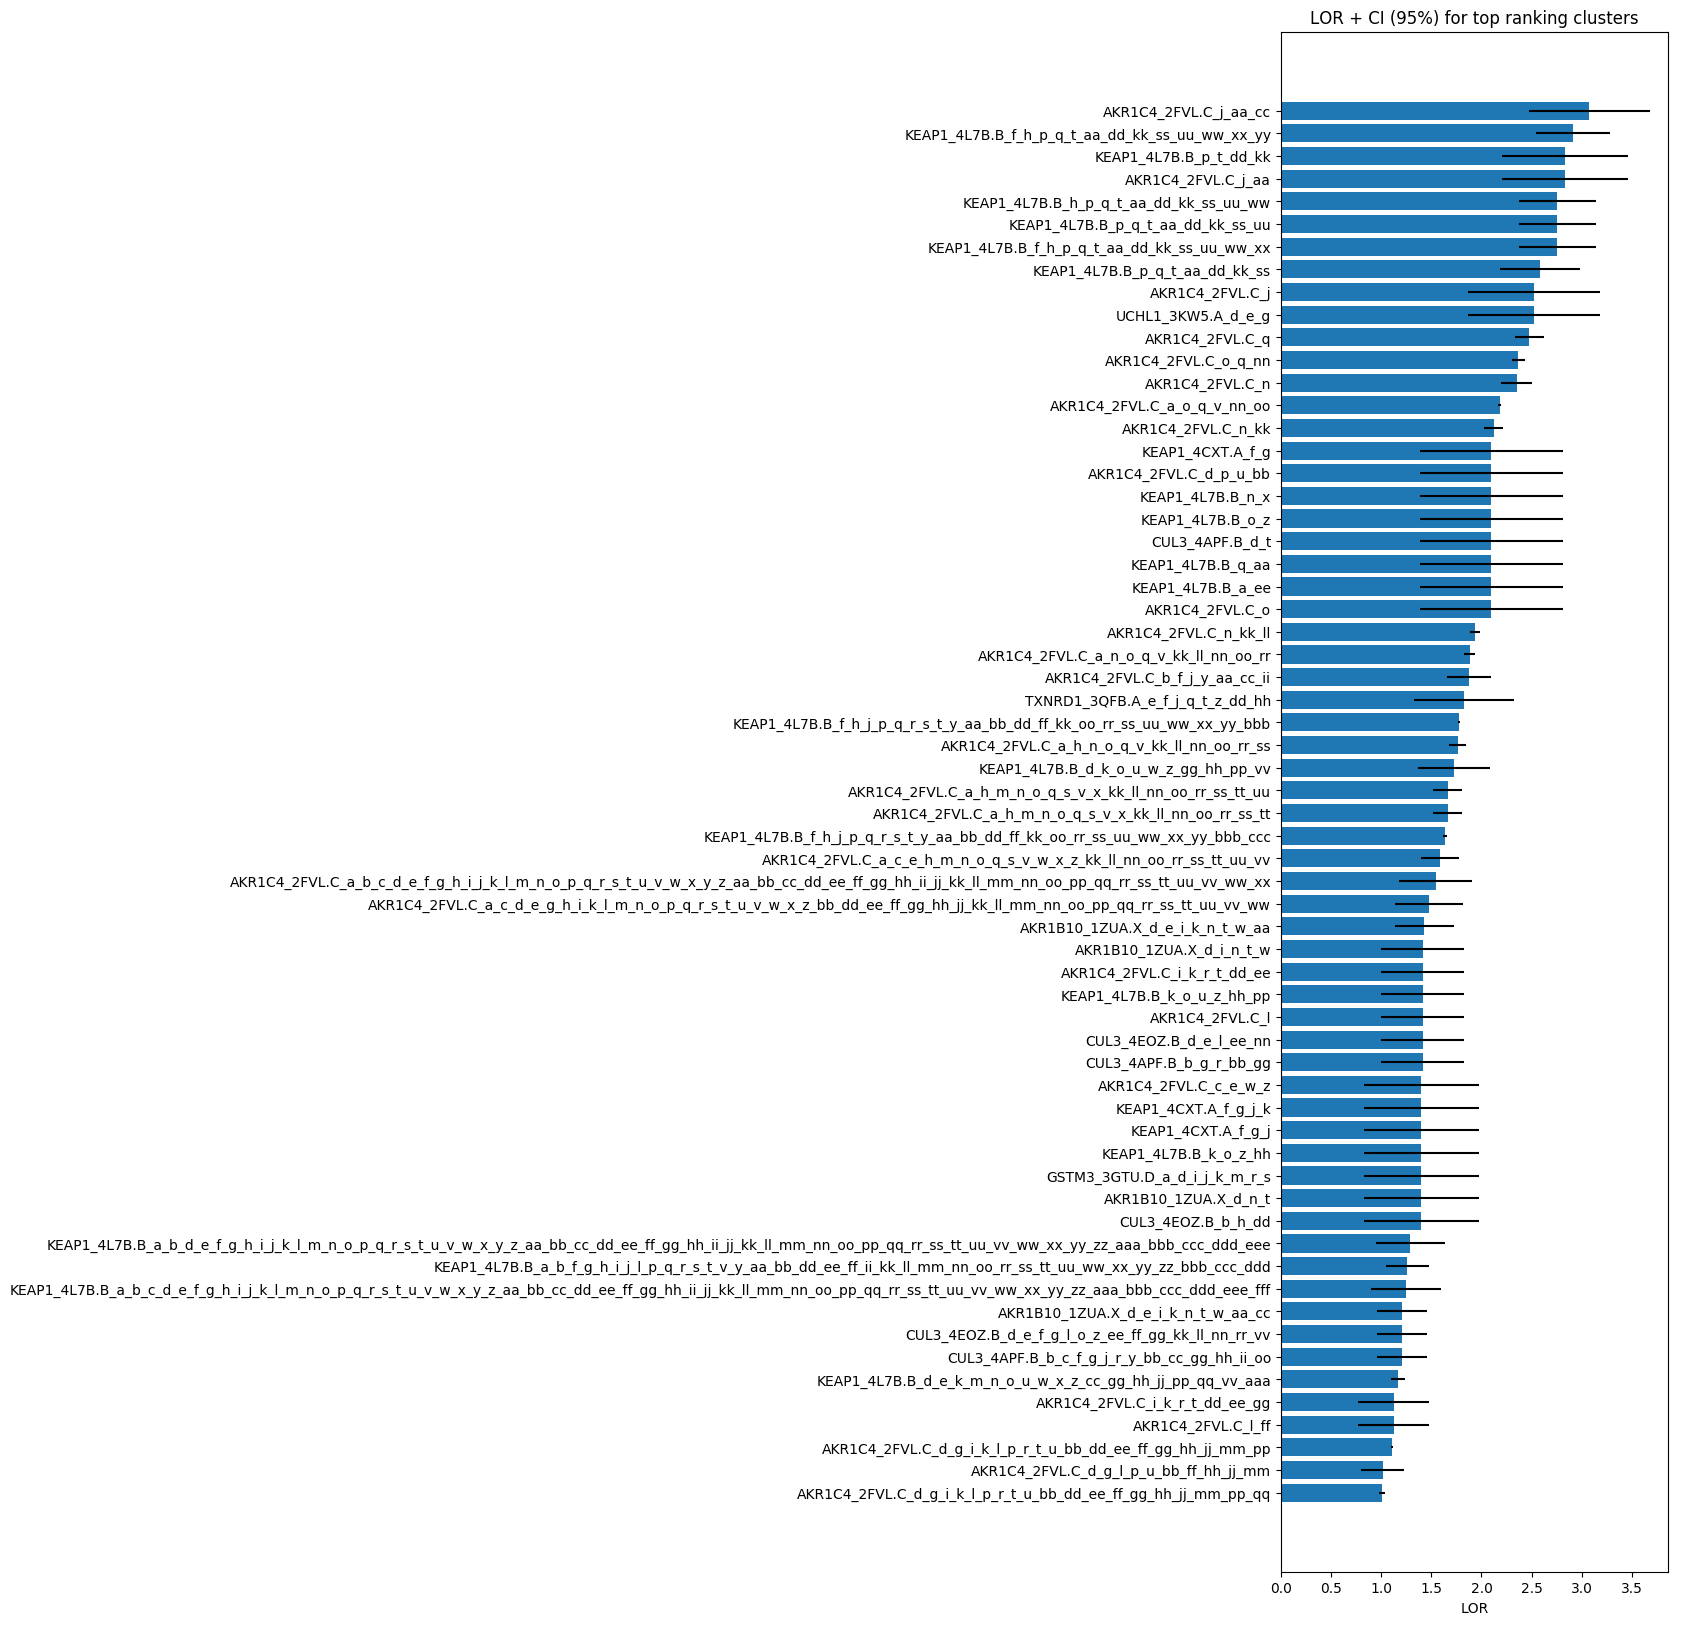

In [34]:
fig, ax = plt.subplots(figsize=(5,20))

ll = FT_sub.sort_values('LOR',ascending=False)

# Example data
people = ll.feature.tolist()
y_pos = np.arange(len(people))
performance = ll.LOR.tolist()
error = ll.LogCI_95.tolist()

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('LOR')
ax.set_title('LOR + CI (95%) for top ranking clusters')

plt.savefig('/home/ebc/Desktop/LOR_plot.png')
plt.show()


## Add probabilities, ROC, AUC, etc to Feature table

##### TO do: Look at https://www.quora.com/How-can-Should-I-create-a-Naive-Bayes-model-with-different-feature-distributions
##### and : https://www.quora.com/What-is-the-best-way-to-use-continuous-variables-for-a-naive-bayes-classifier-Do-we-need-to-cluster-them-or-leave-for-self-learning-Pls-help

#### code to compute p-value and AUC/ ROC